In [ ]:
from pathlib import Path
import random
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torchvision import datasets, transforms



In [54]:
PROJECT_ROOT = Path.cwd()

RAW_DATA_DIR = PROJECT_ROOT / "data" / "images"
PREPARED_DATA_DIR = PROJECT_ROOT / "data" / "prepared"

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

RAW_DATA_DIR


WindowsPath('c:/Data_science/Naturalist/data/images')

In [55]:
assert RAW_DATA_DIR.exists(), "Папка data/images не найдена"
sorted([d.name for d in RAW_DATA_DIR.iterdir() if d.is_dir()])

['Белоспинный дятел',
 'Ворон',
 'Клёст-еловик',
 'Пёстрые дятлы',
 'Снегирь',
 'Уральская неясыть',
 'Чёрный коршун']

In [56]:
classes = sorted([d.name for d in RAW_DATA_DIR.iterdir() if d.is_dir()])

class_counts = {
    cls: len(list((RAW_DATA_DIR / cls).glob("*")))
    for cls in classes
}

class_counts_df = pd.DataFrame.from_dict(
    class_counts, orient="index", columns=["num_images"]
)

class_counts_df


,num_images
Белоспинный дятел,329
Ворон,387
Клёст-еловик,397
Пёстрые дятлы,1
Снегирь,356
Уральская неясыть,212
Чёрный коршун,311


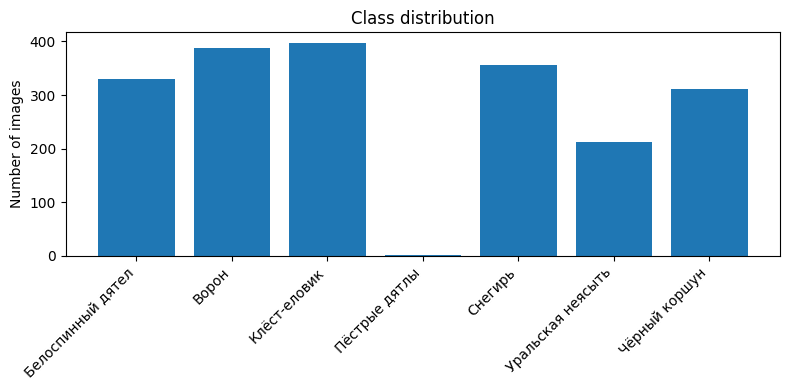

In [57]:
plt.figure(figsize=(8, 4))
plt.bar(class_counts_df.index, class_counts_df["num_images"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of images")
plt.title("Class distribution")
plt.tight_layout()
plt.show()


In [58]:
MIN_IMAGES_PER_CLASS = 50

filtered_classes = [
    cls for cls, cnt in class_counts.items()
    if cnt >= MIN_IMAGES_PER_CLASS
]

removed_classes = [
    cls for cls, cnt in class_counts.items()
    if cnt < MIN_IMAGES_PER_CLASS
]

filtered_classes, removed_classes


(['Белоспинный дятел',
  'Ворон',
  'Клёст-еловик',
  'Снегирь',
  'Уральская неясыть',
  'Чёрный коршун'],
 ['Пёстрые дятлы'])

In [61]:
sizes = []

for cls in filtered_classes:
    for img_path in (RAW_DATA_DIR / cls).glob("*"):
        with Image.open(img_path) as img:
            sizes.append(img.size)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
sizes_df.describe()



,width,height
count,1992.000000,1992.000000
mean,460.544679,398.192771
std,60.897012,70.937526
min,225.000000,262.000000
25%,375.000000,333.000000
50%,500.000000,375.000000
75%,500.000000,500.000000
max,500.000000,500.000000


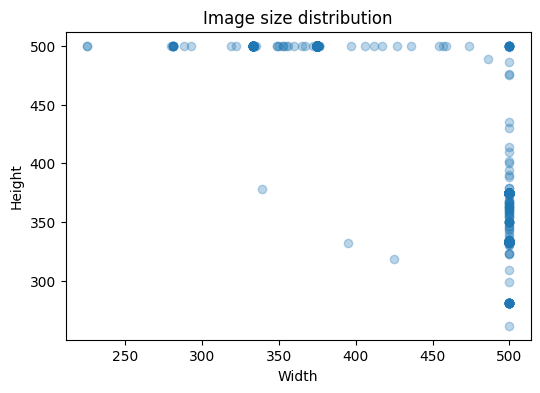

In [62]:
plt.figure(figsize=(6, 4))
plt.scatter(sizes_df["width"], sizes_df["height"], alpha=0.3)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image size distribution")
plt.show()

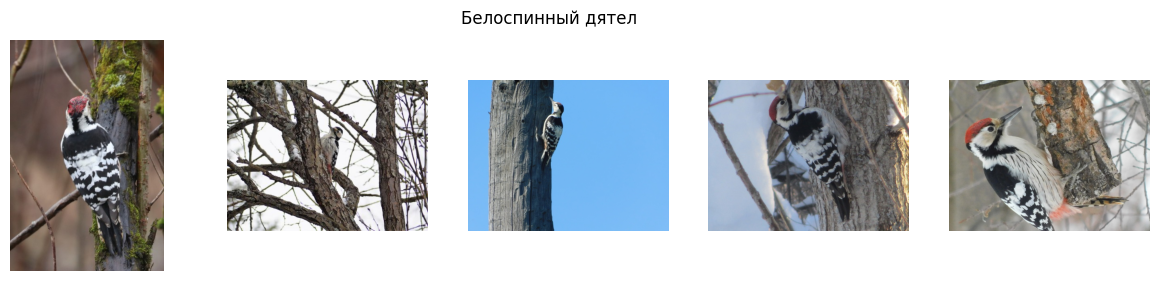

In [63]:
def show_examples(cls, n=5):
    imgs = list((RAW_DATA_DIR / cls).glob("*"))[:n]
    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(imgs):
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(cls)
    plt.show()

show_examples(filtered_classes[0])


In [64]:
if PREPARED_DATA_DIR.exists():
    shutil.rmtree(PREPARED_DATA_DIR)

In [65]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

for split in ["train", "val", "test"]:
    for cls in filtered_classes:
        (PREPARED_DATA_DIR / split / cls).mkdir(parents=True, exist_ok=True)

In [66]:
for cls in filtered_classes:
    images = list((RAW_DATA_DIR / cls).glob("*"))
    random.shuffle(images)

    n = len(images)
    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)

    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train + n_val],
        "test": images[n_train + n_val:]
    }

    for split, imgs in splits.items():
        for img in imgs:
            shutil.copy(img, PREPARED_DATA_DIR / split / cls / img.name)

    print(cls, {k: len(v) for k, v in splits.items()})


Белоспинный дятел {'train': 230, 'val': 49, 'test': 50}
Ворон {'train': 270, 'val': 58, 'test': 59}
Клёст-еловик {'train': 277, 'val': 59, 'test': 61}
Снегирь {'train': 249, 'val': 53, 'test': 54}
Уральская неясыть {'train': 148, 'val': 31, 'test': 33}
Чёрный коршун {'train': 217, 'val': 46, 'test': 48}


In [67]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(PREPARED_DATA_DIR / "train", transform=train_tfms)
val_ds = datasets.ImageFolder(PREPARED_DATA_DIR / "val", transform=eval_tfms)

train_ds.classes, len(train_ds), len(val_ds)

(['Белоспинный дятел',
  'Ворон',
  'Клёст-еловик',
  'Снегирь',
  'Уральская неясыть',
  'Чёрный коршун'],
 1391,
 296)

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
import mlflow
import mlflow.pytorch

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [87]:
PROJECT_ROOT = Path.cwd()

DATA_DIR = PROJECT_ROOT / "data" / "prepared"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"

assert TRAIN_DIR.exists(), "Train data not found"

In [88]:
def get_dvc_data_version(path):
    result = subprocess.run(
        ["dvc", "status", "-c", str(path)],
        capture_output=True,
        text=True
    )
    return result.stdout.strip()

dvc_data_version = get_dvc_data_version(DATA_DIR)
dvc_data_version

"Cache and remote 'local_storage' are in sync."

In [89]:
normalize = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
)

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    normalize
])

In [90]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=eval_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=eval_transform)

num_classes = len(train_dataset.classes)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset.classes

['Белоспинный дятел',
 'Ворон',
 'Клёст-еловик',
 'Снегирь',
 'Уральская неясыть',
 'Чёрный коршун']

In [92]:
class BirdCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(256 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.classifier(x)

In [74]:
class BirdCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

In [95]:
from sklearn.metrics import accuracy_score

def train_experiment(learning_rate, epochs):
    mlflow.end_run()

    model = BirdCNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    with mlflow.start_run():

        # Логируем связь с DVC
        mlflow.log_param("dvc_data_version", dvc_data_version)

        # Гиперпараметры
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", 32)
        mlflow.log_param("model", "BirdCNN")

        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            mlflow.log_metric("train_loss", avg_loss, step=epoch)

        # Evaluation
        model.eval()
        preds, labels = [], []

        with torch.no_grad():
            for images, lbls in test_loader:
                images = images.to(device)
                outputs = model(images)
                _, p = torch.max(outputs, 1)

                preds.extend(p.cpu().numpy())
                labels.extend(lbls.numpy())

        acc = accuracy_score(labels, preds)
        mlflow.log_metric("test_accuracy", acc)

        # Логируем модель
        mlflow.pytorch.log_model(model, "model")

        return acc

In [97]:
mlflow.set_experiment("bird_classification_experiments")

results = {}

for lr in [1e-3, 5e-4, 1e-4]:
    acc = train_experiment(learning_rate=lr, epochs=15)
    results[lr] = acc

results

2025/12/26 16:19:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/26 16:31:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/26 16:42:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


{0.001: 0.6426229508196721,
 0.0005: 0.6065573770491803,
 0.0001: 0.6196721311475409}

In [99]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


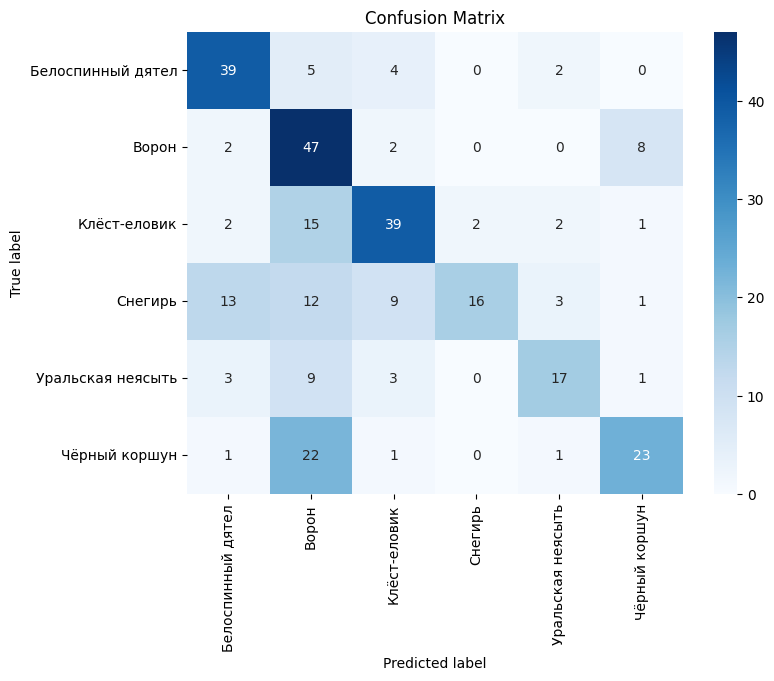

In [101]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=train_ds.classes,
    yticklabels=train_ds.classes
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


In [102]:
print(f"Train accuracy: {train_acc * 100:.2f}%")
print(f"Test accuracy:  {test_acc * 100:.2f}%")


Train accuracy: 70.17%
Test accuracy:  59.34%


In [80]:
train_acc, _, _ = evaluate(train_loader)
test_acc, y_true, y_pred = evaluate(test_loader)

print(f"Train accuracy: {train_acc*100:.2f}%")
print(f"Test accuracy:  {test_acc*100:.2f}%")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

Train accuracy: 70.17%
Test accuracy:  59.34%
                   precision    recall  f1-score   support

Белоспинный дятел       0.65      0.78      0.71        50
            Ворон       0.43      0.80      0.56        59
     Клёст-еловик       0.67      0.64      0.66        61
          Снегирь       0.89      0.30      0.44        54
Уральская неясыть       0.68      0.52      0.59        33
    Чёрный коршун       0.68      0.48      0.56        48

         accuracy                           0.59       305
        macro avg       0.67      0.58      0.59       305
     weighted avg       0.66      0.59      0.59       305



In [107]:
BEST_LR = 1e-3
EPOCHS = 25

import mlflow

mlflow.end_run()
mlflow.set_experiment("bird_classification_final")

with mlflow.start_run(run_name="final_model_lr_1e-3"):
    
    # параметры
    mlflow.log_param("learning_rate", BEST_LR)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("model", "Custom CNN")
    mlflow.log_param("image_size", 224)
    train_losses = []

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        mlflow.log_metric("train_loss", avg_loss, step=epoch)

        print(f"Epoch {epoch+1}/{EPOCHS}, loss={avg_loss:.4f}")



Epoch 1/25, loss=0.7176
Epoch 2/25, loss=0.6985
Epoch 3/25, loss=0.6955
Epoch 4/25, loss=0.6530
Epoch 5/25, loss=0.5864
Epoch 6/25, loss=0.6377
Epoch 7/25, loss=0.6628
Epoch 8/25, loss=0.6420
Epoch 9/25, loss=0.6291
Epoch 10/25, loss=0.5211
Epoch 11/25, loss=0.5468
Epoch 12/25, loss=0.5280
Epoch 13/25, loss=0.5246
Epoch 14/25, loss=0.4908
Epoch 15/25, loss=0.5125
Epoch 16/25, loss=0.5137
Epoch 17/25, loss=0.5044
Epoch 18/25, loss=0.4984
Epoch 19/25, loss=0.4838
Epoch 20/25, loss=0.4647
Epoch 21/25, loss=0.5497
Epoch 22/25, loss=0.4468
Epoch 23/25, loss=0.4240
Epoch 24/25, loss=0.4351
Epoch 25/25, loss=0.4479


In [108]:
train_acc, _, _ = evaluate(train_loader)
test_acc, y_true, y_pred = evaluate(test_loader)

mlflow.log_metric("train_accuracy", train_acc)
mlflow.log_metric("test_accuracy", test_acc)

print(f"Train accuracy: {train_acc*100:.2f}%")
print(f"Test accuracy:  {test_acc*100:.2f}%")

Train accuracy: 88.07%
Test accuracy:  61.97%


In [109]:
from pathlib import Path

MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

model_path = MODELS_DIR / "bird_cnn.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
mlflow.pytorch.log_model(
    model,
    name="bird_cnn_model"   
)